# Imports

In [1]:
import itertools
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import pylab
import random
import tensorflow as tf
import wave

from pathlib import Path
from PIL import Image
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support

# Variables & Hyperparameters

## Variables

In [2]:
DATA_TYPE = "raw_audio"
DIRECTORY = "/content/drive/MyDrive/Classes/CSCE 5222 Feature Engineering/Group Project/"
# DATA_DIR = DIRECTORY + "2k-files/" + DATA_TYPE + "/"
AUDIO_DIR = "/content/AudioMNIST/data/"

## Hyperparameters

In [3]:
N_CHANNELS = 1
N_CLASSES = 10

EPOCHS = 2
BATCH_SIZE = 10
MAX_LEN = None
MAX_SIZE = None

# Load Dataset

## Download Repository

In [4]:
# Clone repository
! git clone https://github.com/soerenab/AudioMNIST

Cloning into 'AudioMNIST'...
remote: Enumerating objects: 30122, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 30122 (delta 0), reused 0 (delta 0), pack-reused 30119
Receiving objects: 100% (30122/30122), 944.54 MiB | 19.80 MiB/s, done.
Resolving deltas: 100% (26/26), done.
Checking out files: 100% (30018/30018), done.


In [5]:
# Get raw audio data
def get_wav_info(wav_file):
    wav = wave.open(wav_file, 'r')
    frames = wav.readframes(-1)
    sound_info = pylab.frombuffer(frames, 'int16')
    frame_rate = wav.getframerate()
    wav.close()
    return sound_info, frame_rate

# Find max sequence length for padding and input shape purposes
min = 1000000000
max = 0
for (r, d, files) in os.walk(AUDIO_DIR):
    for f in files:
        # print(r, f)

        f_in_path = r + "/" + f
        f_out_path = "spectrograms/" + f.split(".")[0] + "spectrogram.png"
        if ".wav" in f:
            sound_info, frame_rate = get_wav_info(f_in_path)
            s = sound_info.shape[0]
            if s < min:
                min = s
            if s > max:
                max = s
    
print(min, max)

14073 47998


In [6]:
MAX_LEN = math.ceil(math.sqrt(max))
MAX_SIZE = MAX_LEN * MAX_LEN

## Train Generator

In [7]:
def gen_train():
    random.seed(42)

    # Get train ids
    data = []
    for j in range(1, 61):
        for i in range(10):
            for k in range(50):
                if j < 49:
                    n = str(j)
                    n = n.rjust(2, "0")
                    n = "%d_%s_%d"%(i, n, k)
                    data.append(n)

    # Iterate through ids
    random.shuffle(data)
    c = 0
    for i, n in enumerate(data):
        usr = n.split("_")[1]
        f_name = AUDIO_DIR + usr + "/" + n + ".wav"
        
        if os.path.exists(f_name):
            sound_info, frame_rate = get_wav_info(f_name)

            s = sound_info.shape[0]

            # Pad
            pad_c = MAX_SIZE - s
            l = int(pad_c / 2)
            sound_info_p = np.pad(sound_info, (l, pad_c - l))

            # Normalize
            sound_info_p_n = (sound_info_p-np.min(sound_info_p))/(np.max(sound_info_p)-np.min(sound_info_p))

            # Reshape
            sound_info_p_n_r = np.reshape(sound_info_p, (MAX_LEN, MAX_LEN))

            # Get y
            f = f_name.split("/")[-1]
            y = f.split("_")[0]
            y = int(y)
        
            # c += 1
            # if c > 20:
            #     break

            yield sound_info_p_n_r, y

## Validation Generator

In [8]:
def gen_val():
    random.seed(42)

    # Get train ids
    data = []
    for j in range(1, 61):
        for i in range(10):
            for k in range(50):
                if j > 48 and j < 55:
                    n = str(j)
                    n = n.rjust(2, "0")
                    n = "%d_%s_%d"%(i, n, k)
                    data.append(n)

    # Iterate through ids
    random.shuffle(data)
    c = 0
    for i, n in enumerate(data):
        usr = n.split("_")[1]
        f_name = AUDIO_DIR + usr + "/" + n + ".wav"
        
        if os.path.exists(f_name):
            sound_info, frame_rate = get_wav_info(f_name)

            s = sound_info.shape[0]

            # Pad
            pad_c = MAX_SIZE - s
            l = int(pad_c / 2)
            sound_info_p = np.pad(sound_info, (l, pad_c - l))

            # Normalize
            sound_info_p_n = (sound_info_p-np.min(sound_info_p))/(np.max(sound_info_p)-np.min(sound_info_p))

            # Reshape
            sound_info_p_n_r = np.reshape(sound_info_p, (MAX_LEN, MAX_LEN))

            # Get y
            f = f_name.split("/")[-1]
            y = f.split("_")[0]
            y = int(y)
        
            # c += 1
            # if c > 20:
            #     break

            yield sound_info_p_n_r, y

## Test Generator

In [9]:
def gen_test():
    random.seed(42)

    # Get train ids
    data = []
    for j in range(1, 61):
        for i in range(10):
            for k in range(50):
                if j > 54:
                    n = str(j)
                    n = n.rjust(2, "0")
                    n = "%d_%s_%d"%(i, n, k)
                    data.append(n)

    # Iterate through ids
    random.shuffle(data)
    c = 0
    for i, n in enumerate(data):
        usr = n.split("_")[1]
        f_name = AUDIO_DIR + usr + "/" + n + ".wav"
        
        if os.path.exists(f_name):
            sound_info, frame_rate = get_wav_info(f_name)

            s = sound_info.shape[0]

            # Pad
            pad_c = MAX_SIZE - s
            l = int(pad_c / 2)
            sound_info_p = np.pad(sound_info, (l, pad_c - l))

            # Normalize
            sound_info_p_n = (sound_info_p-np.min(sound_info_p))/(np.max(sound_info_p)-np.min(sound_info_p))

            # Reshape
            sound_info_p_n_r = np.reshape(sound_info_p, (MAX_LEN, MAX_LEN))

            # Get y
            f = f_name.split("/")[-1]
            y = f.split("_")[0]
            y = int(y)
        
            # c += 1
            # if c > 20:
            #     break

            yield sound_info_p_n_r, y

## Datasets from Generators

In [10]:
train = tf.data.Dataset.from_generator(gen_train, 
                                       output_signature=(tf.TensorSpec(shape=(MAX_LEN, MAX_LEN), dtype=tf.uint8), 
                                                         tf.TensorSpec(shape=(), dtype=tf.uint8)
                                                         )
                                       )
val = tf.data.Dataset.from_generator(gen_val, 
                                     output_signature=(tf.TensorSpec(shape=(MAX_LEN, MAX_LEN), dtype=tf.uint8), 
                                                       tf.TensorSpec(shape=(), dtype=tf.uint8)
                                                       )
                                     )
test = tf.data.Dataset.from_generator(gen_test, 
                                      output_signature=(tf.TensorSpec(shape=(MAX_LEN, MAX_LEN), dtype=tf.uint8), 
                                                        tf.TensorSpec(shape=(), dtype=tf.uint8)
                                                        )
                                      )

In [11]:
# Batch
train = train.batch(BATCH_SIZE, drop_remainder=True, num_parallel_calls = tf.data.AUTOTUNE)
val = val.batch(BATCH_SIZE, drop_remainder=True, num_parallel_calls = tf.data.AUTOTUNE)
test = test.batch(BATCH_SIZE, drop_remainder=True, num_parallel_calls = tf.data.AUTOTUNE)

# Model

## Class

In [12]:
class Trainer():

    def __init__(self, name):
        self.name = name

    def build_model(self, img_height, img_width, n_channels, n_classes):
        self.model = tf.keras.models.Sequential()
        self.model.add(tf.keras.layers.Input(shape=(img_height, img_width, n_channels)))
        self.model.add(tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'))
        self.model.add(tf.keras.layers.BatchNormalization())
        self.model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
        self.model.add(tf.keras.layers.BatchNormalization())
        self.model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
        self.model.add(tf.keras.layers.BatchNormalization())
        self.model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
        self.model.add(tf.keras.layers.BatchNormalization())
        self.model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
        self.model.add(tf.keras.layers.BatchNormalization())
        self.model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
        self.model.add(tf.keras.layers.BatchNormalization())
        self.model.add(tf.keras.layers.Flatten())
        self.model.add(tf.keras.layers.Dense(256, activation='relu'))
        self.model.add(tf.keras.layers.BatchNormalization())
        self.model.add(tf.keras.layers.Dropout(0.5))
        self.model.add(tf.keras.layers.Dense(n_classes, activation='softmax'))

        # Compile model
        self.model.compile(
            loss='sparse_categorical_crossentropy',
            optimizer=tf.keras.optimizers.RMSprop(),
            metrics=['accuracy'],
        )

    def train_model_dataset(self, train_dataset, val_dataset, epochs):
        self.history = self.model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

    def test_model_dataset(self, test_dataset, verbose=True):
        preds =  self.model.predict(test_dataset)
        preds_select = np.apply_along_axis(np.argmax, 1, preds)

        loss, acc = self.model.evaluate(test_dataset, verbose=2)
        
        true = []
        for e in test_dataset.as_numpy_iterator():
            for n in e[1]:
                true.append(n)

        scores = precision_recall_fscore_support(true, preds_select, average='macro')
        pre = scores[0]
        re = scores[1]
        f1 = scores[2]

        cm_labels = [x for x in range(10)]
        cm = confusion_matrix(true, preds_select, labels=cm_labels)

        if verbose:
            print("\nModel Results:")
            print("Loss: %f\nAccuracy: %f\nPrecision: %f\nRecall: %f\nF1: %f"%(loss, acc, pre, re, f1))
            print("\nConfusion Matrix:")
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_labels)
            disp.plot()

        return loss, acc, pre, re, f1, preds, cm

    def plot_loss(self):
        # Plot the loss curves for training and validation.
        history_dict = self.history.history
        loss_values = history_dict['loss']
        val_loss_values = history_dict['val_loss']
        epochs = range(1, len(loss_values)+1)

        plt.figure(figsize=(8,6))
        plt.plot(epochs, loss_values, 'bo', label='Training loss')
        plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
        plt.title('Training and validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def plot_accuracy(self):
        # Plot the accuracy curves for training and validation.
        history_dict = self.history.history
        acc_values = history_dict['accuracy']
        val_acc_values = history_dict['val_accuracy']
        epochs = range(1, len(acc_values)+1)

        plt.figure(figsize=(8,6))
        plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
        plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
        plt.title('Training and validation accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

## Training

### Epochs = 2

In [ ]:
# Build
model = Trainer(DATA_TYPE)
model.build_model(MAX_LEN, MAX_LEN, N_CHANNELS, N_CLASSES)

In [ ]:
# Train
model.train_model_dataset(train, val, EPOCHS)

Epoch 1/2
    582/Unknown - 248s 423ms/step - loss: 1.5399 - accuracy: 0.5014

<ipython-input-25-ee9e14214391>:33: RuntimeWarning: overflow encountered in short_scalars
  sound_info_p_n = (sound_info_p-np.min(sound_info_p))/(np.max(sound_info_p)-np.min(sound_info_p))


2400/2400 [==============================] - 1029s 428ms/step - loss: 1.1245 - accuracy: 0.6194 - val_loss: 0.7932 - val_accuracy: 0.7230
Epoch 2/2
2400/2400 [==============================] - 999s 416ms/step - loss: 0.7016 - accuracy: 0.7580 - val_loss: 0.7730 - val_accuracy: 0.7390


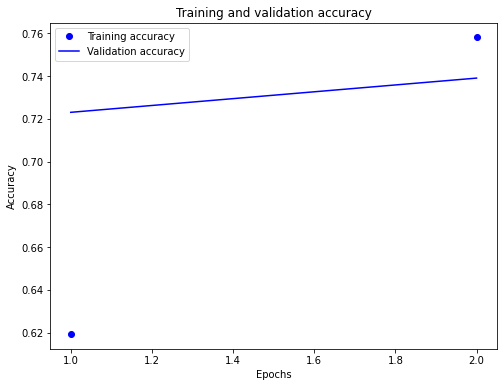

In [ ]:
# Plot training accuracy
model.plot_accuracy()

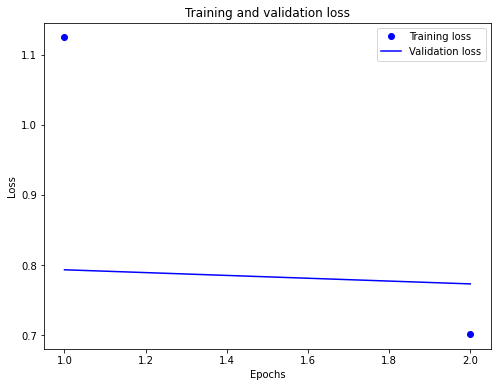

In [ ]:
# Plot training loss
model.plot_loss()

300/300 [==============================] - 33s 110ms/step
300/300 - 28s - loss: 0.7410 - accuracy: 0.7347 - 28s/epoch - 92ms/step

Model Results:
Loss: 0.741027
Accuracy: 0.734667
Precision: 0.746876
Recall: 0.734667
F1: 0.725576

Confusion Matrix:


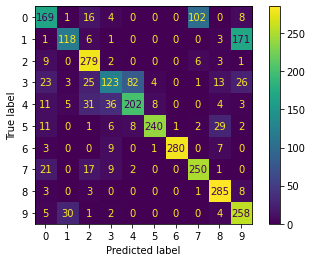

In [ ]:
# Get test scores
_ = model.test_model_dataset(test)

### Epochs = 10

In [13]:
EPOCHS = 10

In [14]:
# Build
model = Trainer(DATA_TYPE)
model.build_model(MAX_LEN, MAX_LEN, N_CHANNELS, N_CLASSES)

In [15]:
# Train
model.train_model_dataset(train, val, EPOCHS)

Epoch 1/10
    582/Unknown - 220s 375ms/step - loss: 1.5387 - accuracy: 0.4950

<ipython-input-7-5a35c8a019ec>:33: RuntimeWarning: overflow encountered in short_scalars
  sound_info_p_n = (sound_info_p-np.min(sound_info_p))/(np.max(sound_info_p)-np.min(sound_info_p))


2400/2400 [==============================] - 934s 388ms/step - loss: 1.1234 - accuracy: 0.6166 - val_loss: 1.4414 - val_accuracy: 0.6017
Epoch 2/10
2400/2400 [==============================] - 932s 388ms/step - loss: 0.6998 - accuracy: 0.7578 - val_loss: 0.6618 - val_accuracy: 0.7690
Epoch 3/10
2400/2400 [==============================] - 1023s 426ms/step - loss: 0.5260 - accuracy: 0.8201 - val_loss: 2.4664 - val_accuracy: 0.7317
Epoch 4/10
2400/2400 [==============================] - 1023s 426ms/step - loss: 0.4133 - accuracy: 0.8608 - val_loss: 0.9896 - val_accuracy: 0.6833
Epoch 5/10
2400/2400 [==============================] - 1024s 427ms/step - loss: 0.3312 - accuracy: 0.8902 - val_loss: 1.1050 - val_accuracy: 0.6543
Epoch 6/10
2400/2400 [==============================] - 1048s 437ms/step - loss: 0.2655 - accuracy: 0.9093 - val_loss: 0.7478 - val_accuracy: 0.8043
Epoch 7/10
2400/2400 [==============================] - 1055s 439ms/step - loss: 0.2063 - accuracy: 0.9304 - val_loss: 

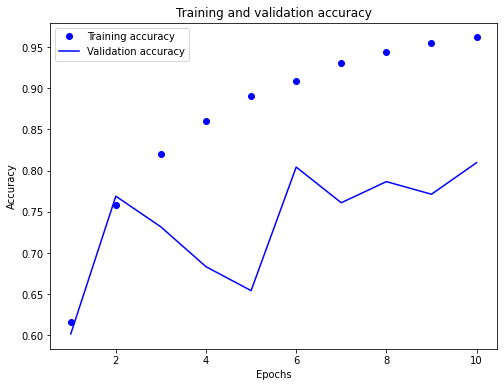

In [16]:
# Plot training accuracy
model.plot_accuracy()

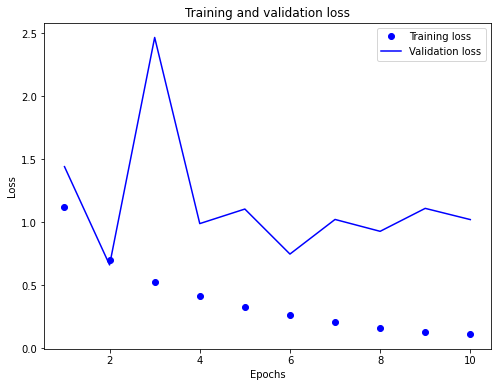

In [17]:
# Plot training loss
model.plot_loss()

300/300 [==============================] - 31s 101ms/step
300/300 - 27s - loss: 0.9362 - accuracy: 0.8343 - 27s/epoch - 91ms/step

Model Results:
Loss: 0.936243
Accuracy: 0.834333
Precision: 0.844516
Recall: 0.834333
F1: 0.833827

Confusion Matrix:


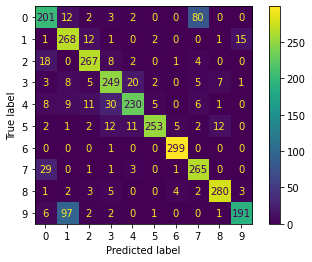

In [18]:
# Get test scores
_ = model.test_model_dataset(test)

# Bottom